# Competitive Analysis of Luxury Car Market

I have scraped the latest 5000 posts from the Edmunds discussion forum for - [Entry Level Luxury Performance Sedans](https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans).

### Packages required

In [2]:
import sys
sys.path.insert(0,'chromedriver')
from selenium import webdriver
from selenium.webdriver.common.by import By
from datetime import datetime
from time import sleep
import pandas as pd
from nltk.tokenize import word_tokenize
from math import log
from matplotlib import pyplot as plt
from statsmodels.api import OLS
from numpy import nan, inf
from nltk.corpus import stopwords
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
%matplotlib inline

### Scraper

In [3]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--headless')

In [4]:
wd = webdriver.Chrome('./chromedriver',options=chrome_options)
base_url = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p'

C:\Users\varun\AppData\Local\Temp\ipykernel_23068\2674574073.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  wd = webdriver.Chrome('./chromedriver',options=chrome_options)


In [4]:
wd.get(base_url + str(1))
max_pagenum = wd.find_element(By.XPATH, "//span[contains(@id, 'PagerBefore')]/a[contains(@class, 'LastPage')]")
max_pagenum = int(max_pagenum.text)
start_page = 1
if max_pagenum > 100:
    start_page = max_pagenum - 100

In [5]:
comments = pd.DataFrame({"username":[], "date":[], "comment": []})

def addWebDataToDataFrame(page):
    wd.get(base_url + str(page))
    element = wd.find_elements(By.TAG_NAME, 'blockquote')
    for e in element:
        try:
            wd.execute_script("""
                var element = arguments[0];
                element.parentNode.removeChild(element);
                """, e)
        except:
            pass
    sections = wd.find_elements(By.XPATH, "//ul[contains(@class, 'MessageList')]/li")

    for i, section in enumerate(sections):
        user = section.find_element(By.XPATH, "div/div/div/span/a[contains(@class, 'Username')]")
        user = user.text

        time = section.find_element(By.XPATH, "div/div/div/span/a/time")
        time = time.get_attribute("datetime")
        time = datetime.strptime(time, "%Y-%m-%dT%H:%M:%S+00:00")
        time = f"{time.year}-{time.month:02}"

        comment = section.find_element(By.XPATH, "div/div/div/div[contains(@class, 'Message')]")
        comment = comment.text
        comments.loc[len(comments.index)] = [user, time, comment]
        if len(comments.index) == 5000:
            return False
    return True

In [6]:
for pagenum in range(start_page, max_pagenum+1):
    try:
        sleep(0.01)
        scrape = addWebDataToDataFrame(pagenum)
        if not scrape:
            break
    except:
        print(f"Error in {pagenum}")

comments[:10]

,username,date,comment
0,nyccarguy,2014-02,@roadburner\nYou hit the nail on the head. You...
1,stickguy,2014-02,now that I have inherited my Acura TL back (a ...
2,nyccarguy,2014-02,@stickguy\nEven with the coil packs you had to...
3,roadburner,2014-02,@nyccarguy\nExactly. You have to evaluate all ...
4,laurasdada,2014-02,Heresy if repeated over on Chronic Car Buyers!...
5,stickguy,2014-02,Which Lexus model is this?
6,Mr_Shiftright,2014-02,"$1200/yr is a very sober estimate and IMO, ver..."
7,stickguy,2014-02,My TL even with all the miles has not averaged...
8,Mr_Shiftright,2014-02,Here's something to make your blood run cold:\...
9,m6user,2014-02,might have run up around that much.\nOf course...


In [7]:
comments.drop_duplicates(inplace=True)
comments.to_csv("./data.csv", index=False)

### Zipf's Law

In [24]:
comments = pd.read_csv("./data.csv")
tokens = comments["comment"].map(lambda s: word_tokenize(str(s).lower()))

In [25]:
token_freq = pd.Series(tokens.sum()).value_counts()
token_freq[:10]

the    24023
,      21930
.      20888
a      11476
i      10993
to     10009
and     9807
of      7371
it      6696
is      6408
dtype: int64

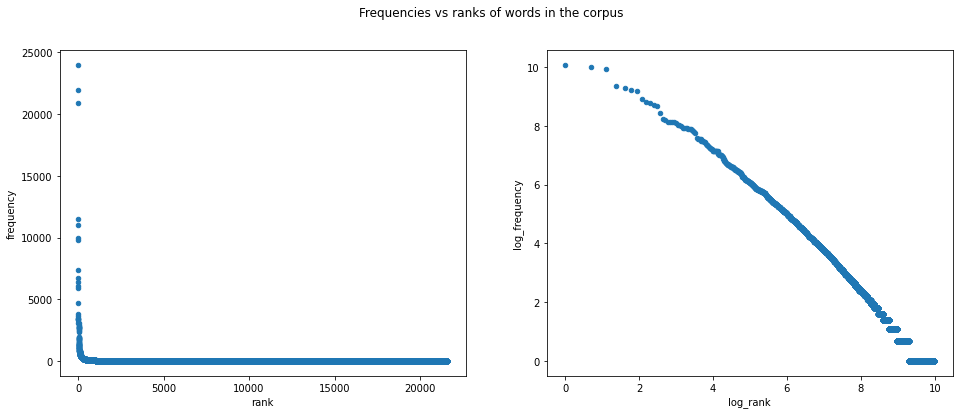

In [26]:
token_df = pd.DataFrame(token_freq).reset_index().rename({"index": "token", 0: "frequency"}, axis=1).reset_index().rename({"index": "rank"}, axis=1)
token_df["rank"] = token_df["rank"] + 1

token_df["log_rank"] = token_df["rank"].map(lambda x: log(x))
token_df["log_frequency"] = token_df["frequency"].map(lambda x: log(x))

n_Xn = token_df.loc[token_df["frequency"].idxmin(),"frequency"] * token_df.shape[0]
token_df["rank_Xreg"] = token_df["rank"].map(lambda x: log(x/n_Xn))

fig, ax = plt.subplots(1,2, figsize=(16, 6))
token_df.plot.scatter(ax=ax[0], x='rank', y='frequency')
token_df.plot.scatter(ax=ax[1], x='log_rank', y='log_frequency')
fig.suptitle('Frequencies vs ranks of words in the corpus')
plt.show()

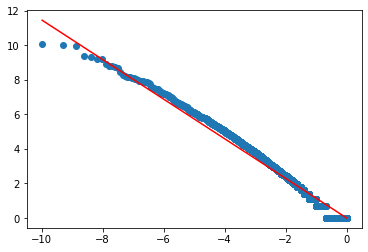

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                          4.970e+05
Date:                Wed, 14 Sep 2022   Prob (F-statistic):                        0.00
Time:                        08:18:58   Log-Likelihood:                         -7188.9
No. Observations:               21586   AIC:                                  1.438e+04
Df Residuals:                   21585   BIC:                                  1.439e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [27]:
X = token_df.loc[:, "rank_Xreg"].values.reshape(-1, 1)
Y = token_df.loc[:, "log_frequency"].values.reshape(-1, 1)

mod = OLS(Y,X)
fii = mod.fit()
Y_pred = fii.predict(X)

plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

print(fii.summary())

From the regression, we see that the Co-efficient value turns out to be `-1.14` with a high t-value rejecting the null hypothesis. This proves Zipf's law econometrically as the coefficient is very close to `-1`.

### Top-10 Brands

In [28]:
brand_model = pd.read_csv("./model_to_brand.csv").drop_duplicates()
brand_synonyms = dict(brand_model.set_index("Model")["Brand"])

# 1. List of features from a predefined list
features = ['interior', 'power', 'cargo', 'engine', 'design', 'mileage', 'comfort', 'weight',
            'reliability', 'safety', 'performance', 'experience', 'legroom', 'clearance', 'transmission',
            'speed', 'luxury', 'steering', 'style', 'price', 'fuel', 'family']

# 2. List of brands from the csv of model-brand mapping
brands = brand_model[["Brand"]].drop_duplicates().reset_index(drop=True)
brands = brands[brands["Brand"].map(lambda s: s not in  ["wife", "sedan", "seat", "car"] and s not in features)]

tokens = tokens.map(
    lambda list_words:
        [word for word in list_words if word not in brand_synonyms.keys()] + \
        [brand_synonyms[word] for word in list_words if word in brand_synonyms.keys()]
)

stop_words = set(stopwords.words('english'))

tokens = tokens.map(lambda list_words: [i for i in list_words if i.isalpha() and i not in stop_words])

In [29]:
token_freq = pd.Series(tokens.sum()).value_counts()
token_freq = pd.DataFrame(token_freq).reset_index().rename({"index": "token", 0: "frequency"}, axis=1)

top_brands = token_freq.merge(brands, left_on="token", right_on="Brand", how="inner").sort_values(by="frequency", ascending=False)[["Brand", "frequency"]]
top_brands[:10]

,Brand,frequency
0,audi,3231
1,bmw,2160
2,acura,1910
3,cadillac,805
4,honda,765
5,volkswagen,487
6,mercedes,434
7,polestar,434
8,infiniti,407
9,lexus,353


In [30]:
token_freq.to_csv("./frequencies.csv",index=False)
top_brands[:10].to_csv("./top10_brands.csv",index=False)

### Lift Between brands

In [31]:
def getLift(token_1, token_2):
    N = len(tokens)
    count_1 = tokens.map(lambda x: token_1 in x).sum() + 10**(-6)
    count_2 = tokens.map(lambda x: token_2 in x).sum() + 10**(-6)
    count_12 = tokens.map(lambda x: token_1 in x and token_2 in x).sum()
    return N*count_12/(count_1*count_2)

getLift("hyundai","lexus")

3.5248446860810616

In [32]:
top_10_brands = top_brands["Brand"].values[:10]
_1 = pd.DataFrame(index=top_10_brands, columns=top_10_brands)
lift_brands = _1.apply(lambda col: pd.Series(name=col.name, data=[getLift(col.name, row) for row in col.index.values]), axis=1) \
                .rename(columns=pd.Series(top_10_brands))

In [33]:
for i, row in enumerate(_1.index.values):
    for j, col in enumerate(_1.columns.values):
        if i==j:
            lift_brands.loc[row,col] = ""
        if i > j:
            lift_brands.loc[row,col] = ""

lift_brands

,audi,bmw,acura,cadillac,honda,volkswagen,mercedes,polestar,infiniti,lexus
audi,,1.733413,1.720362,2.253013,1.763131,2.476224,3.174564,1.686969,2.705728,2.654971
bmw,,,1.240927,1.722519,1.21736,1.266513,2.876541,1.460483,2.063946,2.163854
acura,,,,1.763747,3.394139,1.163818,2.805133,1.384666,3.724219,2.978761
cadillac,,,,,1.175151,1.066001,3.994868,1.270237,3.240642,4.075722
honda,,,,,,2.193462,1.81709,1.578631,1.991228,2.120529
volkswagen,,,,,,,1.780181,2.226117,1.706934,1.35119
mercedes,,,,,,,,1.653661,4.58891,6.000724
polestar,,,,,,,,,1.687162,1.363363
infiniti,,,,,,,,,,7.11627
lexus,,,,,,,,,,


### MDS Plot of brands

In [34]:
top_20_brands = top_brands["Brand"].values[:10]
_1 = pd.DataFrame(index=top_20_brands, columns=top_20_brands)
dissimilarity = _1.apply(lambda col: pd.Series(name=col.name, data=[1/getLift(col.name, row) for row in col.index.values]), axis=1) \
                    .rename(columns=pd.Series(top_20_brands))

for i, row in enumerate(_1.index.values):
    for j, col in enumerate(_1.columns.values):
        if i==j:
            dissimilarity.loc[row,col] = 0
        if dissimilarity.loc[row,col] == inf:
            dissimilarity.loc[row,col] = nan

dissimilarity = dissimilarity.fillna(dissimilarity.max().max())
dissimilarity

,audi,bmw,acura,cadillac,honda,volkswagen,mercedes,polestar,infiniti,lexus
audi,0.000000,0.576897,0.581273,0.443850,0.567173,0.403841,0.315004,0.592779,0.369586,0.376652
bmw,0.576897,0.000000,0.805849,0.580545,0.821449,0.789570,0.347640,0.684705,0.484509,0.462138
acura,0.581273,0.805849,0.000000,0.566975,0.294626,0.859241,0.356489,0.722196,0.268513,0.335710
cadillac,0.443850,0.580545,0.566975,0.000000,0.850954,0.938086,0.250321,0.787254,0.308581,0.245355
honda,0.567173,0.821449,0.294626,0.850954,0.000000,0.455900,0.550330,0.633460,0.502203,0.471581
volkswagen,0.403841,0.789570,0.859241,0.938086,0.455900,0.000000,0.561741,0.449213,0.585846,0.740088
mercedes,0.315004,0.347640,0.356489,0.250321,0.550330,0.561741,0.000000,0.604719,0.217917,0.166647
polestar,0.592779,0.684705,0.722196,0.787254,0.633460,0.449213,0.604719,0.000000,0.592711,0.733480
infiniti,0.369586,0.484509,0.268513,0.308581,0.502203,0.585846,0.217917,0.592711,0.000000,0.140523
lexus,0.376652,0.462138,0.335710,0.245355,0.471581,0.740088,0.166647,0.733480,0.140523,0.000000


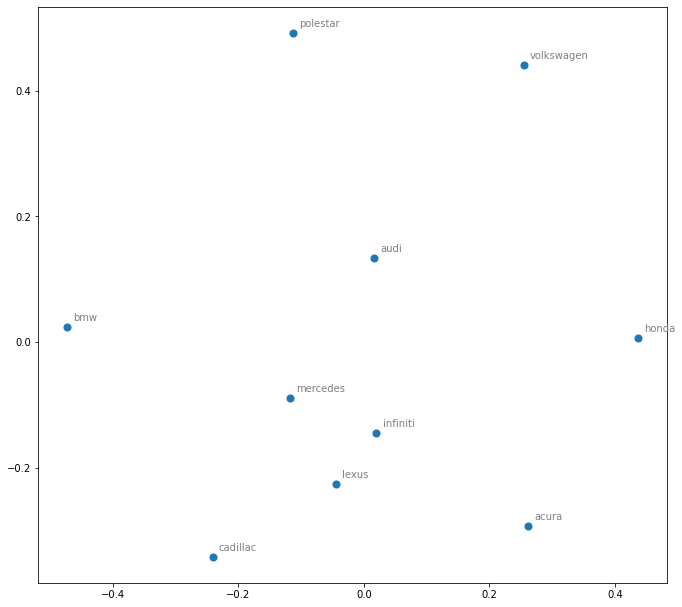

In [35]:
mds = MDS(n_components=2, random_state=1, dissimilarity="precomputed")
mds.fit(dissimilarity)
points = pd.DataFrame(mds.embedding_).rename(columns={0:"dim-1", 1:"dim-2"})

# kmeans = KMeans(n_clusters=3, random_state=0)
# colors = ['#DF2020', '#81DF20', '#2095DF', '#000000']
# points['cluster'] = pd.Series(map(lambda x : colors[x], kmeans.fit_predict(points[["dim-1","dim-2"]])))

ax = plt.axes([0,0,2,2])
ax.set_aspect(aspect='equal')

plt.scatter(points.iloc[:,0], points.iloc[:,1], s=50)

for i in range(points.shape[0]):
    ax.annotate(dissimilarity.index[i], (points.iloc[i,0]+0.01, points.iloc[i,1]+0.01), color='grey')

plt.savefig("Brands.jpg", bbox_inches = 'tight')

### Insights from Brand comparisons

Mercedes, Lexus, and Infiniti are in extreme proximity as clearly observed in the MDS plot. This implies that when people compare Mercedes with other brands, Lexus and Infiniti are the most talked about. Hence, Mercedes should concentrate on acquiring customers from the other two brands and should avoid customer churns to them. The same advice would also hold for Lexus and Infiniti, as they should make themselves stand out.

BMW and Honda seem to have carved out separate niches that make them stand out from other brands significantly.

### Top Features

In [38]:
top_features = token_freq[token_freq["token"].map(lambda x: x in features)].sort_values(by="frequency", ascending=False).reset_index(drop=True)[["token", "frequency"]]
top_features[:5]

,token,frequency
0,performance,3122
1,price,2604
2,reliability,1357
3,interior,936
4,fuel,876


In [39]:
top_features[:10].to_csv("./top10_features.csv",index=False)

In [41]:
_1 = pd.DataFrame()
_1["brand"] = top_brands["Brand"].values[:10]

_2 = pd.DataFrame()
_2["feature"] = top_features["token"].values[:5]

brand_feature = _1.merge(_2, how="cross")
brand_feature["lift"] = brand_feature.apply(lambda x: getLift(x[0],x[1]), axis=1)

group_dictionaries = brand_feature.groupby(["brand"]).groups
for brand in group_dictionaries:
    print(f"Lift ratios between brand and features for brand: {brand.capitalize()}")
    display(brand_feature.iloc[group_dictionaries[brand]].sort_values(by="lift", ascending=False).reset_index(drop=True)[:5])
    

Lift ratios between brand and features for brand: Acura


,brand,feature,lift
0,acura,interior,2.076220
1,acura,fuel,1.622271
2,acura,reliability,1.492043
3,acura,price,1.487399
4,acura,performance,1.448090


Lift ratios between brand and features for brand: Audi


,brand,feature,lift
0,audi,interior,1.885524
1,audi,reliability,1.832028
2,audi,price,1.737714
3,audi,fuel,1.682207
4,audi,performance,1.667496


Lift ratios between brand and features for brand: Bmw


,brand,feature,lift
0,bmw,reliability,1.661681
1,bmw,interior,1.639047
2,bmw,performance,1.592177
3,bmw,price,1.587518
4,bmw,fuel,1.254517


Lift ratios between brand and features for brand: Cadillac


,brand,feature,lift
0,cadillac,price,1.718701
1,cadillac,reliability,1.611195
2,cadillac,interior,1.280001
3,cadillac,performance,1.256160
4,cadillac,fuel,0.879395


Lift ratios between brand and features for brand: Honda


,brand,feature,lift
0,honda,interior,2.196702
1,honda,fuel,1.987088
2,honda,reliability,1.881012
3,honda,performance,1.649837
4,honda,price,1.578301


Lift ratios between brand and features for brand: Infiniti


,brand,feature,lift
0,infiniti,interior,1.795841
1,infiniti,price,1.773982
2,infiniti,reliability,1.561265
3,infiniti,performance,1.485318
4,infiniti,fuel,1.211296


Lift ratios between brand and features for brand: Lexus


,brand,feature,lift
0,lexus,price,1.677054
1,lexus,interior,1.622443
2,lexus,performance,1.384542
3,lexus,reliability,1.356176
4,lexus,fuel,0.943867


Lift ratios between brand and features for brand: Mercedes


,brand,feature,lift
0,mercedes,interior,2.101927
1,mercedes,price,2.027200
2,mercedes,reliability,1.681647
3,mercedes,performance,1.507433
4,mercedes,fuel,1.026410


Lift ratios between brand and features for brand: Polestar


,brand,feature,lift
0,polestar,fuel,2.307230
1,polestar,reliability,1.863096
2,polestar,interior,1.716354
3,polestar,price,1.612580
4,polestar,performance,1.600747


Lift ratios between brand and features for brand: Volkswagen


,brand,feature,lift
0,volkswagen,fuel,2.636191
1,volkswagen,reliability,1.919588
2,volkswagen,price,1.693074
3,volkswagen,interior,1.610401
4,volkswagen,performance,1.535638


Most strongly associated feature for each brand are

| Brand | Feature |
| --- | ------ |
| Acura | Interior |
| Audi | Interior |
| BMW | Reliability |
| Cadillac | Price |
| Honda | Interior |
| Infiniti | Interior |
| Lexus | Price |
| Mercedes | Interior |
| Polestar | Fuel |
| Volkswagen | Fuel |

We can see that `Interior` is the most talked about feature for many of these brands in the latest discussions on the forum. There are some surprising results as well, for instance, BMW markets itself as *"the ultimate driving machine"*, but their customers are instead talking about Reliability and Interior more than Performance.

### Advice for Clients

Assuming positive sentiments, we would give the following advice to the brands

* For BMW, especially in entry-level luxury sedans, performance is not even the top attribute when people talk about BMWs, and the association (the lift score) is not that strong as well. Given that the marketing campaigns highlight that particular feature, we would suggest altering advertisements because the current ones are proving ineffective.=
* When comparing attributes, Volkswagen and Polestar customers seem to have very similar profiles. Thus both companies should be aware of potential customer churn when the other brand is concerned.
* For Cadillac, people do not tend to associate the brand with great fuel efficiency. This is an area where the marketing team for the brand should greatly improve customer perception.

### Aspirational Brand & Business Impact

In [23]:
brand_feature.groupby("brand").agg({"lift": sum}).sort_values("lift", ascending=False)[:5]

,lift
brand,
volkswagen,9.394893
honda,9.292940
polestar,9.100007
audi,8.804969
mercedes,8.344617


Volkswagen, although being the 6th most talked about in the forum, has the highest cumulative lift score with the top 5 features. Thus, we would say that Volkswagen is the most aspirational brand in terms of our data. Volkswagen should concentrate on the entry-level luxury sedan market as they already appear to have a significant foothold and very good associations with the features in that segment.